In [2]:
from pdata import *
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib inline  

matplotlib.rcParams.update({'font.size': 16})

# initialize pdata
dat = pdata()

# domain
xmin = 0.0
ymin = 0.0
zmin = 0.0
xmax = 100.0
ymax = 1.0
zmax = 1.0
xnodes = 50
ynodes = 1
znodes = 1

# set simulation
dat.simulation = psimulation(simulation_type='subsurface')

# flow grid
dat.grid = pgrid(type='structured', upper_bounds=[xmax,ymax,zmax], nxyz=[xnodes,ynodes,znodes])

# flow material properties
dat.add(pmaterial(name='fracture', id=1, porosity=0.1, permeability=[1e-13], 
                tortuosity=1.0,soil_compressibility_function='BANDIS_UNCOUPLED',
                 soil_reference_pressure=10.e6,soil_compressibility=1e-9))

# set regions
dat.add(pregion(name='all', coordinates_lower=[xmin,ymin,zmin], coordinates_upper=[xmax,ymax,zmax]))
dat.add(pregion(name='left', face='west', coordinates_lower=[xmin,ymin,zmin], coordinates_upper=[xmin,ymax,zmax]))
dat.add(pregion(name='right', face='east', coordinates_lower=[xmax,ymin,zmin], coordinates_upper=[xmax,ymax,zmax]))

# Add time
dat.time = ptime(tf=[1.25e6,'s'],dti=[100,'s'],dtf=[1.0e4,'s'])

# set flow conditions
dat.add(pflow(name='well'))
dat.add(pflow_variable(name='pressure', type='dirichlet', valuelist=[20.0e6]), index='well')

dat.add(pflow(name='farfield'))
dat.add(pflow_variable(name='pressure', type='dirichlet', valuelist=[10.0e6]), index='farfield')

# set initial condition
dat.add(pinitial_condition(name='initial', flow='farfield', region='all'))

# set boundary conditions
dat.add(pboundary_condition(name='well', region='left', flow='well'))
dat.add(pboundary_condition(name='farfield', region='right', flow='farfield'))

# set stratigraphy
dat.add(pstrata(region='all', material='fracture'))

# flow output
# uncomment if you want to viz in visit/paraview
dat.output = poutput(time_list=['s',0.0, 0.25e6, 0.5e6, 0.75e6, 1.0e6, 1.25e6],format_list=['tecplot point'],
                    variables_list=['LIQUID_PRESSURE','LIQUID_DENSITY','POROSITY','PERMEABILITY'])

#reference_stress_state
dat.reference_stress_state.value_list=[-25.e06, -25.E06, -25.E06, -0.E06, -0.E06, -0.E06]

# write input file
dat.write('pflotran.in')

# print input file to screen
# uncomment the line below if you'd like to see the input file on the screen
dat.print_inputfile_to_screen()

SIMULATION
  SIMULATION_TYPE SUBSURFACE
  PROCESS_MODELS
    SUBSURFACE_FLOW flow
      MODE richards
    / 
  / 
END

SUBSURFACE

REFERENCE_STRESS_STATE -25000000.0 -25000000.0 -25000000.0 -0.0 -0.0 -0.0 

GRID
  TYPE structured
  BOUNDS
    0.0 0.0 0.0 
    100.0 1.0 1.0 
  /
  NXYZ 50 1 1 
END

TIME
  FINAL_TIME 1250000.0 s
  INITIAL_TIMESTEP_SIZE 100 s
  MAXIMUM_TIMESTEP_SIZE 10000.0 s
END

MATERIAL_PROPERTY fracture
  ID 1
  CHARACTERISTIC_CURVES default
  POROSITY 0.1
  TORTUOSITY 1.0
  PERMEABILITY
    PERM_ISO 1.000d-13
  /
  SOIL_COMPRESSIBILITY_FUNCTION BANDIS_UNCOUPLED
  SOIL_COMPRESSIBILITY 1.000d-09
  SOIL_REFERENCE_PRESSURE 10000000.0
END

OUTPUT
  TIMES  s 0.0 250000.0 500000.0 750000.0 1000000.0 1250000.0
  FORMAT TECPLOT POINT
  VARIABLES 
    LIQUID_PRESSURE
    LIQUID_DENSITY
    POROSITY
    PERMEABILITY
  /
END

CHARACTERISTIC_CURVES default
  SATURATION_FUNCTION VAN_GENUCHTEN
   ALPHA 0.0001
   M 0.5
   LIQUID_RESIDUAL_SATURATION 0.1
  / 
  PERMEABILITY_FUNCTION M

In [9]:
#note use the following when running in terminal since subprocess PIPE doesnt work with ipython notebook
#dat.run(input='pflotran.in', exe='/Users/satkarra/src/pflotran-geomechanics-regression/src/pflotran/pflotran')

#use subprocess.call or os.system instead
ierr = os.system('/home/danny/local/bandis_Feb2017/src/pflotran/pflotran')

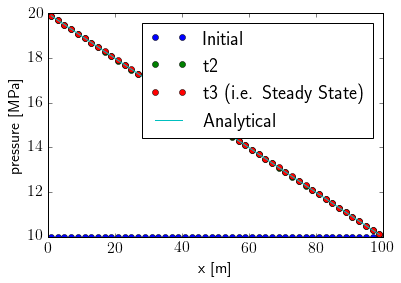

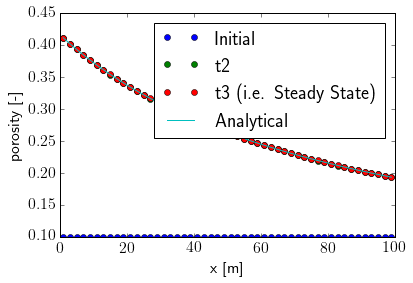

In [14]:
import csv, pudb, os
import numpy as np
import mpmath
import matplotlib.pyplot as plt
parent_dir = os.getcwd()

#select options
fifty_nodes = True
const_compressibility = False #Set to False for BANDIS_UNCOUPLED

if fifty_nodes:
    x_length = 50;
    plt_x_start = 13; #starts plotting at x = r = 1.1
    text_append = ''
else:
    x_length = 1001;
    plt_x_start = 8; #starts plotting at x = r = 1.1
    text_append = '_1001';


i = 0; x = [0]*x_length; j  = 0; 
p1 = [0]*len(x);
permfault=x; permnear = x; perminj = x; permpastfault = x;
den = [0]*x_length; S = [0]*x_length; T = [0]*x_length; u = [0]*x_length;
phi = [0]*x_length;
filename = 'pflotran'+text_append+'-000.tec'
with open (filename,'r') as csvfile:  
    reader = csv.reader(csvfile, delimiter= ' ')
    for row in reader:
        i = i+1
        if i >= 4:
            x[j]=float(row[1])
            p1[j] = float(row[7])/10**6
            den[j] =   1000. #float(row[9])
            phi[j] = float(row[11])
            j+=1 


plt.figure(1);plt.plot(x,p1,'o'); plt.hold('on')
plt.figure(2);plt.plot(x,phi,'o'); plt.hold('on')

i = 0; x = [0]*x_length; j  = 0; 
p1 = [0]*len(x);
permfault=x; permnear = x; perminj = x; permpastfault = x;
den = [0]*x_length; S = [0]*x_length; T = [0]*x_length; u = [0]*x_length;
filename = 'pflotran'+text_append+'-004.tec'
with open (filename,'r') as csvfile:  
    reader = csv.reader(csvfile, delimiter= ' ')
    for row in reader:
        i = i+1
        if i >= 4:
            x[j]=float(row[1])
            p1[j] = float(row[7])/10**6
            den[j] =   1000. #float(row[9])
            phi[j] = float(row[11])
            j+=1 

plt.figure(1);plt.plot(x,p1,'o'); plt.hold('on');
plt.figure(2);plt.plot(x,phi,'o'); plt.hold('on')

i = 0; x = [0]*x_length; j  = 0; 
p1 = [0]*len(x);
permfault=x; permnear = x; perminj = x; permpastfault = x;
den = [0]*x_length; S = [0]*x_length; T = [0]*x_length; u = [0]*x_length;
filename = 'pflotran'+text_append+'-005.tec'
with open (filename,'r') as csvfile:  
    reader = csv.reader(csvfile, delimiter= ' ')
    for row in reader:
        i = i+1
        if i >= 4:
            x[j]=float(row[1])
            p1[j] = float(row[7])/10**6
            den[j] =   1000. #float(row[9])
            phi[j] = float(row[11])
            j+=1 

if const_compressibility:
    p_anal = [0]*len(x); phi_anal = [0]*len(x);
    p_ref = 10; # MPa
    phi0 = 0.1
    alpha = 10**(-3); #1/MPa
    for i in xrange(0,len(p_anal)):
        p_anal[i] = -0.1*x[i] + 20 # MPa
        phi_anal[i] = phi0 + alpha*(p_anal[i]-p_ref)
#         print i
else:
    # analytical solution for pressure and porosity (BANDIS)
    p_anal = [0]*len(x); phi_anal = [0]*len(x);
    BANDIS_A  = 2.8e-5; #m/MPa
    BANDIS_B  = 2.8e-1; #1/MPa
    MAXIMUM_APERTURE = 1.e-4;  #m
    bp = MAXIMUM_APERTURE #m
    sigma = -25.0 # MPa
    for i in xrange(0,len(p_anal)):
        p_anal[i] = -0.1*x[i] + 20 # MPa
        effective_stress = sigma + p1[i]
        phi_anal[i] = (1/bp)*(MAXIMUM_APERTURE + (BANDIS_A*effective_stress)/(1-BANDIS_B*effective_stress)) 
#         print i

#analytical solution for pressure and porosity (CONSTANT)

plt.figure(1);plt.plot(x,p1,'o'); plt.hold('on');
plt.plot(x,p_anal,'-')
plt.legend(['Initial','t2','t3 (i.e. Steady State)','Analytical']); 
plt.xlabel('x [m]');plt.ylabel('pressure [MPa]');
#if const_compressibility:
#    plt.title('CONSTANT compressibility function')
#else:
#    plt.title('BANDIS\_UNCOUPLED compressibility function')
plt.savefig('bandis_uncoupled_1d_presure.pdf')
    
plt.figure(2);plt.plot(x,phi,'o'); plt.hold('on')
plt.plot(x,phi_anal,'-')
plt.legend(['Initial','t2','t3 (i.e. Steady State)','Analytical']); 
plt.xlabel('x [m]');plt.ylabel('porosity [-]');
#if const_compressibility:
#    plt.title('CONSTANT compressibility function')
#else:
#    plt.title('BANDIS\_UNCOUPLED compressibility function')
# plt.axis([0,100,0.1,0.11])
plt.savefig('bandis_uncoupled_1d_porosity.pdf')

plt.figure(3);
plt.plot()
plt.show()

In [4]:
# initialize pdata
dat = pdata()

# domain
xmin = 0.0
ymin = 0.0
zmin = 0.0
xmax = 100.0
ymax = 1.0
zmax = 1.0
xnodes = 50
ynodes = 1
znodes = 1

# set simulation
dat.simulation = psimulation(simulation_type='subsurface')

# flow grid
dat.grid = pgrid(type='structured', upper_bounds=[xmax,ymax,zmax], nxyz=[xnodes,ynodes,znodes])

# flow material properties
dat.add(pmaterial(name='fracture', id=1, porosity=0.1, permeability=[1e-13], tortuosity=1.0,soil_compressibility_function='CONSTANT',
                 soil_reference_pressure=10.e6,soil_compressibility=1e-9))

# set regions
dat.add(pregion(name='all', coordinates_lower=[xmin,ymin,zmin], coordinates_upper=[xmax,ymax,zmax]))
dat.add(pregion(name='left', face='west', coordinates_lower=[xmin,ymin,zmin], coordinates_upper=[xmin,ymax,zmax]))
dat.add(pregion(name='right', face='east', coordinates_lower=[xmax,ymin,zmin], coordinates_upper=[xmax,ymax,zmax]))

# Add time
dat.time = ptime(tf=[1.25e6,'s'],dti=[100,'s'],dtf=[1.0e4,'s'])

# set flow conditions
dat.add(pflow(name='well'))
dat.add(pflow_variable(name='pressure', type='dirichlet', valuelist=[20.0e6]), index='well')

dat.add(pflow(name='farfield'))
dat.add(pflow_variable(name='pressure', type='dirichlet', valuelist=[10.0e6]), index='farfield')

# set initial condition
dat.add(pinitial_condition(name='initial', flow='farfield', region='all'))

# set boundary conditions
dat.add(pboundary_condition(name='well', region='left', flow='well'))
dat.add(pboundary_condition(name='farfield', region='right', flow='farfield'))

# set stratigraphy
dat.add(pstrata(region='all', material='fracture'))

# flow output
# uncomment if you want to viz in visit/paraview
dat.output = poutput(time_list=['s',0.0, 0.25e6, 0.5e6, 0.75e6, 1.0e6, 1.25e6],format_list=['tecplot point'],
                    variables_list=['LIQUID_PRESSURE','LIQUID_DENSITY','POROSITY','PERMEABILITY'])

#reference_stress_state
dat.reference_stress_state.value_list=[-25.e06, -25.E06, -25.E06, -0.E06, -0.E06, -0.E06]

# write input file
dat.write('pflotran.in')

# print input file to screen
# uncomment the line below if you'd like to see the input file on the screen
# dat.print_inputfile_to_screen()

SIMULATION
  SIMULATION_TYPE SUBSURFACE
  PROCESS_MODELS
    SUBSURFACE_FLOW flow
      MODE richards
    / 
  / 
END

SUBSURFACE

REFERENCE_STRESS_STATE -25000000.0 -25000000.0 -25000000.0 -0.0 -0.0 -0.0 

GRID
  TYPE structured
  BOUNDS
    0.0 0.0 0.0 
    100.0 1.0 1.0 
  /
  NXYZ 50 1 1 
END

TIME
  FINAL_TIME 1250000.0 s
  INITIAL_TIMESTEP_SIZE 100 s
  MAXIMUM_TIMESTEP_SIZE 10000.0 s
END

MATERIAL_PROPERTY fracture
  ID 1
  CHARACTERISTIC_CURVES default
  POROSITY 0.1
  TORTUOSITY 1.0
  PERMEABILITY
    PERM_ISO 1.000d-13
  /
  SOIL_COMPRESSIBILITY_FUNCTION CONSTANT
  SOIL_COMPRESSIBILITY 1.000d-09
  SOIL_REFERENCE_PRESSURE 10000000.0
END

OUTPUT
  TIMES  s 0.0 250000.0 500000.0 750000.0 1000000.0 1250000.0
  FORMAT TECPLOT POINT
  VARIABLES 
    LIQUID_PRESSURE
    LIQUID_DENSITY
    POROSITY
    PERMEABILITY
  /
END

CHARACTERISTIC_CURVES default
  SATURATION_FUNCTION VAN_GENUCHTEN
   ALPHA 0.0001
   M 0.5
   LIQUID_RESIDUAL_SATURATION 0.1
  / 
  PERMEABILITY_FUNCTION MUALEM_VG

In [5]:
#note use the following when running in terminal since subprocess PIPE doesnt work with ipython notebook
#dat.run(input='pflotran.in', exe='/Users/satkarra/src/pflotran-geomechanics-regression/src/pflotran/pflotran')

#use subprocess.call or os.system instead
ierr = os.system('/home/danny/local/bandis2/pflotran-dev-bandis/src/pflotran/pflotran')

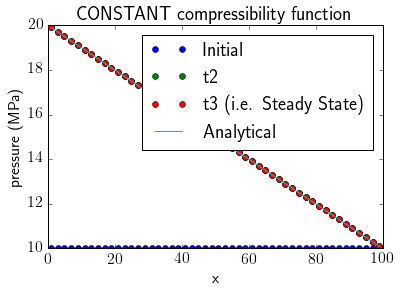

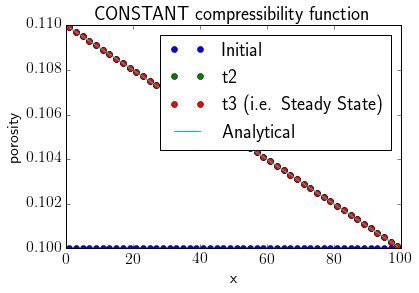

In [6]:
import csv, pudb, os
import numpy as np
import mpmath
import matplotlib.pyplot as plt
parent_dir = os.getcwd()

#select options
fifty_nodes = True
const_compressibility = True #Set to False for BANDIS_UNCOUPLED

if fifty_nodes:
    x_length = 50;
    plt_x_start = 13; #starts plotting at x = r = 1.1
    text_append = ''
else:
    x_length = 1001;
    plt_x_start = 8; #starts plotting at x = r = 1.1
    text_append = '_1001';


i = 0; x = [0]*x_length; j  = 0; 
p1 = [0]*len(x);
permfault=x; permnear = x; perminj = x; permpastfault = x;
den = [0]*x_length; S = [0]*x_length; T = [0]*x_length; u = [0]*x_length;
phi = [0]*x_length;
filename = 'pflotran'+text_append+'-000.tec'
with open (filename,'r') as csvfile:  
    reader = csv.reader(csvfile, delimiter= ' ')
    for row in reader:
        i = i+1
        if i >= 4:
            x[j]=float(row[1])
            p1[j] = float(row[7])/10**6
            den[j] =   1000. #float(row[9])
            phi[j] = float(row[11])
            j+=1 


plt.figure(1);plt.plot(x,p1,'o'); plt.hold('on')
plt.figure(2);plt.plot(x,phi,'o'); plt.hold('on')

i = 0; x = [0]*x_length; j  = 0; 
p1 = [0]*len(x);
permfault=x; permnear = x; perminj = x; permpastfault = x;
den = [0]*x_length; S = [0]*x_length; T = [0]*x_length; u = [0]*x_length;
filename = 'pflotran'+text_append+'-004.tec'
with open (filename,'r') as csvfile:  
    reader = csv.reader(csvfile, delimiter= ' ')
    for row in reader:
        i = i+1
        if i >= 4:
            x[j]=float(row[1])
            p1[j] = float(row[7])/10**6
            den[j] =   1000. #float(row[9])
            phi[j] = float(row[11])
            j+=1 

plt.figure(1);plt.plot(x,p1,'o'); plt.hold('on');
plt.figure(2);plt.plot(x,phi,'o'); plt.hold('on')

i = 0; x = [0]*x_length; j  = 0; 
p1 = [0]*len(x);
permfault=x; permnear = x; perminj = x; permpastfault = x;
den = [0]*x_length; S = [0]*x_length; T = [0]*x_length; u = [0]*x_length;
filename = 'pflotran'+text_append+'-005.tec'
with open (filename,'r') as csvfile:  
    reader = csv.reader(csvfile, delimiter= ' ')
    for row in reader:
        i = i+1
        if i >= 4:
            x[j]=float(row[1])
            p1[j] = float(row[7])/10**6
            den[j] =   1000. #float(row[9])
            phi[j] = float(row[11])
            j+=1 

if const_compressibility:
    p_anal = [0]*len(x); phi_anal = [0]*len(x);
    p_ref = 10; # MPa
    phi0 = 0.1
    alpha = 10**(-3); #1/MPa
    for i in xrange(0,len(p_anal)):
        p_anal[i] = -0.1*x[i] + 20 # MPa
        phi_anal[i] = phi0 + alpha*(p_anal[i]-p_ref)
#         print i
else:
    # analytical solution for pressure and porosity (BANDIS)
    p_anal = [0]*len(x); phi_anal = [0]*len(x);
    BANDIS_A  = 2.8e-5; #m/MPa
    BANDIS_B  = 2.8e-1; #1/MPa
    MAXIMUM_APERTURE = 1.e-4;  #m
    bp = MAXIMUM_APERTURE #m
    sigma = -25.0 # MPa
    for i in xrange(0,len(p_anal)):
        p_anal[i] = -0.1*x[i] + 20 # MPa
        effective_stress = sigma + p1[i]
        phi_anal[i] = (1/bp)*(MAXIMUM_APERTURE + (BANDIS_A*effective_stress)/(1-BANDIS_B*effective_stress)) 
#         print i

#analytical solution for pressure and porosity (CONSTANT)

plt.figure(1);plt.plot(x,p1,'o'); plt.hold('on');
plt.plot(x,p_anal,'-')
plt.legend(['Initial','t2','t3 (i.e. Steady State)','Analytical']); 
plt.xlabel('x');plt.ylabel('pressure (MPa)');
if const_compressibility:
    plt.title('CONSTANT compressibility function')
else:
    plt.title('BANDIS\_UNCOUPLED compressibility function')

plt.figure(2);plt.plot(x,phi,'o'); plt.hold('on')
plt.plot(x,phi_anal,'-')
plt.legend(['Initial','t2','t3 (i.e. Steady State)','Analytical']); 
plt.xlabel('x');plt.ylabel('porosity');
if const_compressibility:
    plt.title('CONSTANT compressibility function')
else:
    plt.title('BANDIS\_UNCOUPLED compressibility function')
# plt.axis([0,100,0.1,0.11])
plt.show()